<a href="https://colab.research.google.com/github/ichsansan/AnomalyDetection/blob/master/SML_Research_Smart_Signal-Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inisial
Mempersiapkan library yang diperlukan, dan memasukkan data input yang diperlukan seperti data history BFP B, dan sensor tag beserta namanya.

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import matplotlib
from sklearn.preprocessing import StandardScaler
from os import listdir
from google.colab import drive
from scipy.signal import lfilter, butter, cheby1

plt.style.use('seaborn')
drive.mount('/content/drive/')
matplotlib.rcParams['figure.figsize'] = (14,5)
matplotlib.rcParams['figure.dpi'] = 100

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
bfpb = pd.read_csv("/content/drive/My Drive/Work/Data Paiton 1/eds-feedwater1-perequipment/BFP B.csv", index_col="timestamp")
bfpb.index = pd.to_datetime(bfpb.index)
sensorgroup = pd.read_excel("/content/drive/My Drive/Work/Data Paiton 1/SENSOR GROUP BFP-B REV.11022020.xlsx", skiprows=[0], index_col="NAME")

## List tag dan keterangan nama sensornya
Berikut ini adalah list tag sensor pada equipment BFP B dan keterangan nama sensornya yang disusun secara urut

In [3]:
for i,c in enumerate(bfpb.columns):
    print(f"{i}. {c}      \t{sensorgroup['DESC'].loc[c]}")

0. 1FI-FW067      	BFP B DISCH FLOW
1. 1FK-FW061      	BFP B RECIRC VLV CONTROL
2. 1FT-FW067      	BFP B DISCH FLOW DP
3. 1FX-FW070      	BFP B MIN FLOW LINE FLOW
4. 1SK-FW078      	BFP B SPEED     CONTROL
5. 1ST-FW472      	BFP B SPEED
6. 1ZT-FW078      	BFP B SPEED CONTROL POSITION
7. 1ZT-FW411      	BFP B RECIRC VLV POSN
8. 1VT-FW451AOL      	BFP B MTR RSDIAL DE BRG VIBRN
9. 1VT-FW452AOL      	BFP B MTR RADIAL NDE VIBRN
10. 1VT-FW460AOL      	BFP B HCPLG AXIAL PRI VIBRATION
11. 1VT-FW461AOL      	BFP B HCPLG RADIAL PRI VIBRATION
12. 1VT-FW462AOL      	BFP B HCPLG RADIAL SEC VIBRATION
13. 1VT-FW463AOL      	BFP B RADIAL DE BRG VIBRN #1
14. 1VT-FW464AOL      	BFP B RADIAL DE BRG VIBRN #2
15. 1VT-FW473AOL      	BFP B AXIAL NDE BRG VIBRN
16. 1VT-FW474AOL      	BFP B RADIAL NDE BRG VIBRN #2
17. 1VT-FW475AOL      	BFP B RADIAL NDE BRG VIBRN #1
18. 1FX-FW073      	BFP B BALANCE LINE FLOW
19. 1IT-FW052      	BFP B MOTOR CURR
20. 1LSL-OL446      	BFP B VOITH CPLG OIL LEVEL LOW
21. 1PDS-OL445

# Preprocessing
Data yang sudah di-*load* kemudian diproses dan diolah datanya agar dapat dengan mudah diproses selanjutnya. Pada bagian ini data 'timestamp' diubah menjadi bentuk `pandas.datetime` atau `numpy.datetime64` agar dapat ditampilkan di grafik. Kemudian data sensor yang hilang akan teridentifikasi sebagai `nan` atau Not a Number, data tersebut diubah menjadi angka 0 agar bisa digunakan untuk penghitungan *means* dan *standard deviasi*-nya.
Kemudian membuat variabel baru yang berisi nilai BFP B yang sudah dinormalisasi untuk dimasukkan ke dalam autoencoder.

In [0]:
timestamp = np.array(bfpb.index)
pdts = pd.to_datetime(timestamp)
bfpb_arr = bfpb.to_numpy()
bfpb_arr = np.nan_to_num(bfpb_arr)

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(bfpb_arr)

# Autoencoder 
Autoencoder adalah salah satu tipe *Artificial Neural Network* yang salah satu fungsinya untuk menghilangkan noise. Pada proses ini autoencoder digunakan untuk mendeteksi data yang dianggap anomali dengan cara mentraining data yang dianggap tidak anomali saja. Sehingga ketika diinputkan data yang dianggap anomali, hasilnya akan membelok sedikit. Nilai deviasi dari belokan tersebut jika melewati batas tertentu akan kami anggap anomali. 

Struktur NN Autoencoder:
* Layer input: 70 Neuron
* Hidden layer 1: 30 Neuron
* Layer output : 70 Neuron

In [6]:
from keras.models import load_model
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

namamodel = "/content/drive/My Drive/Work/Data Paiton 1/eds-feedwater1-5mnt/Research models/model_AutoEncoder-Full_6_linear.h5"
model = load_model(namamodel)
model.summary()
Y = model.predict(X)

nilai_pred = scaler.inverse_transform(Y)

Using TensorFlow backend.













Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_2 (Dense)              (None, 70)                2170      
Total params: 4,300
Trainable params: 4,300
Non-trainable params: 0
_________________________________________________________________


Berikut ini adalah tampilan perbandingan sinyal asli dengan sinyal setelah di-autoencoder pada masing-masing tag di BFP B dengan timestamp kecil, yaitu pada tanggal 1-11 Juni. Grafik warna biru merupakan nilai sensor aslinya, dan warna merah merupakan sinyal prediksi. 
Berdasarkan informasi dari tim Engineer, equipment BFP B dapat dikatakan mati apabila nilai dari tag BFP B SPEED di bawah dari yang seharusnya, atau arus motor di bawah yang seharusnya. Misalkan jika BFP B SPEED pada operasi normalnya bernilai 4000-5000 RPM, maka jika nilainya di bawah 3500 kami anggap mati.


['2019-06-01' '2019-06-04' '2019-06-07' '2019-06-10']


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



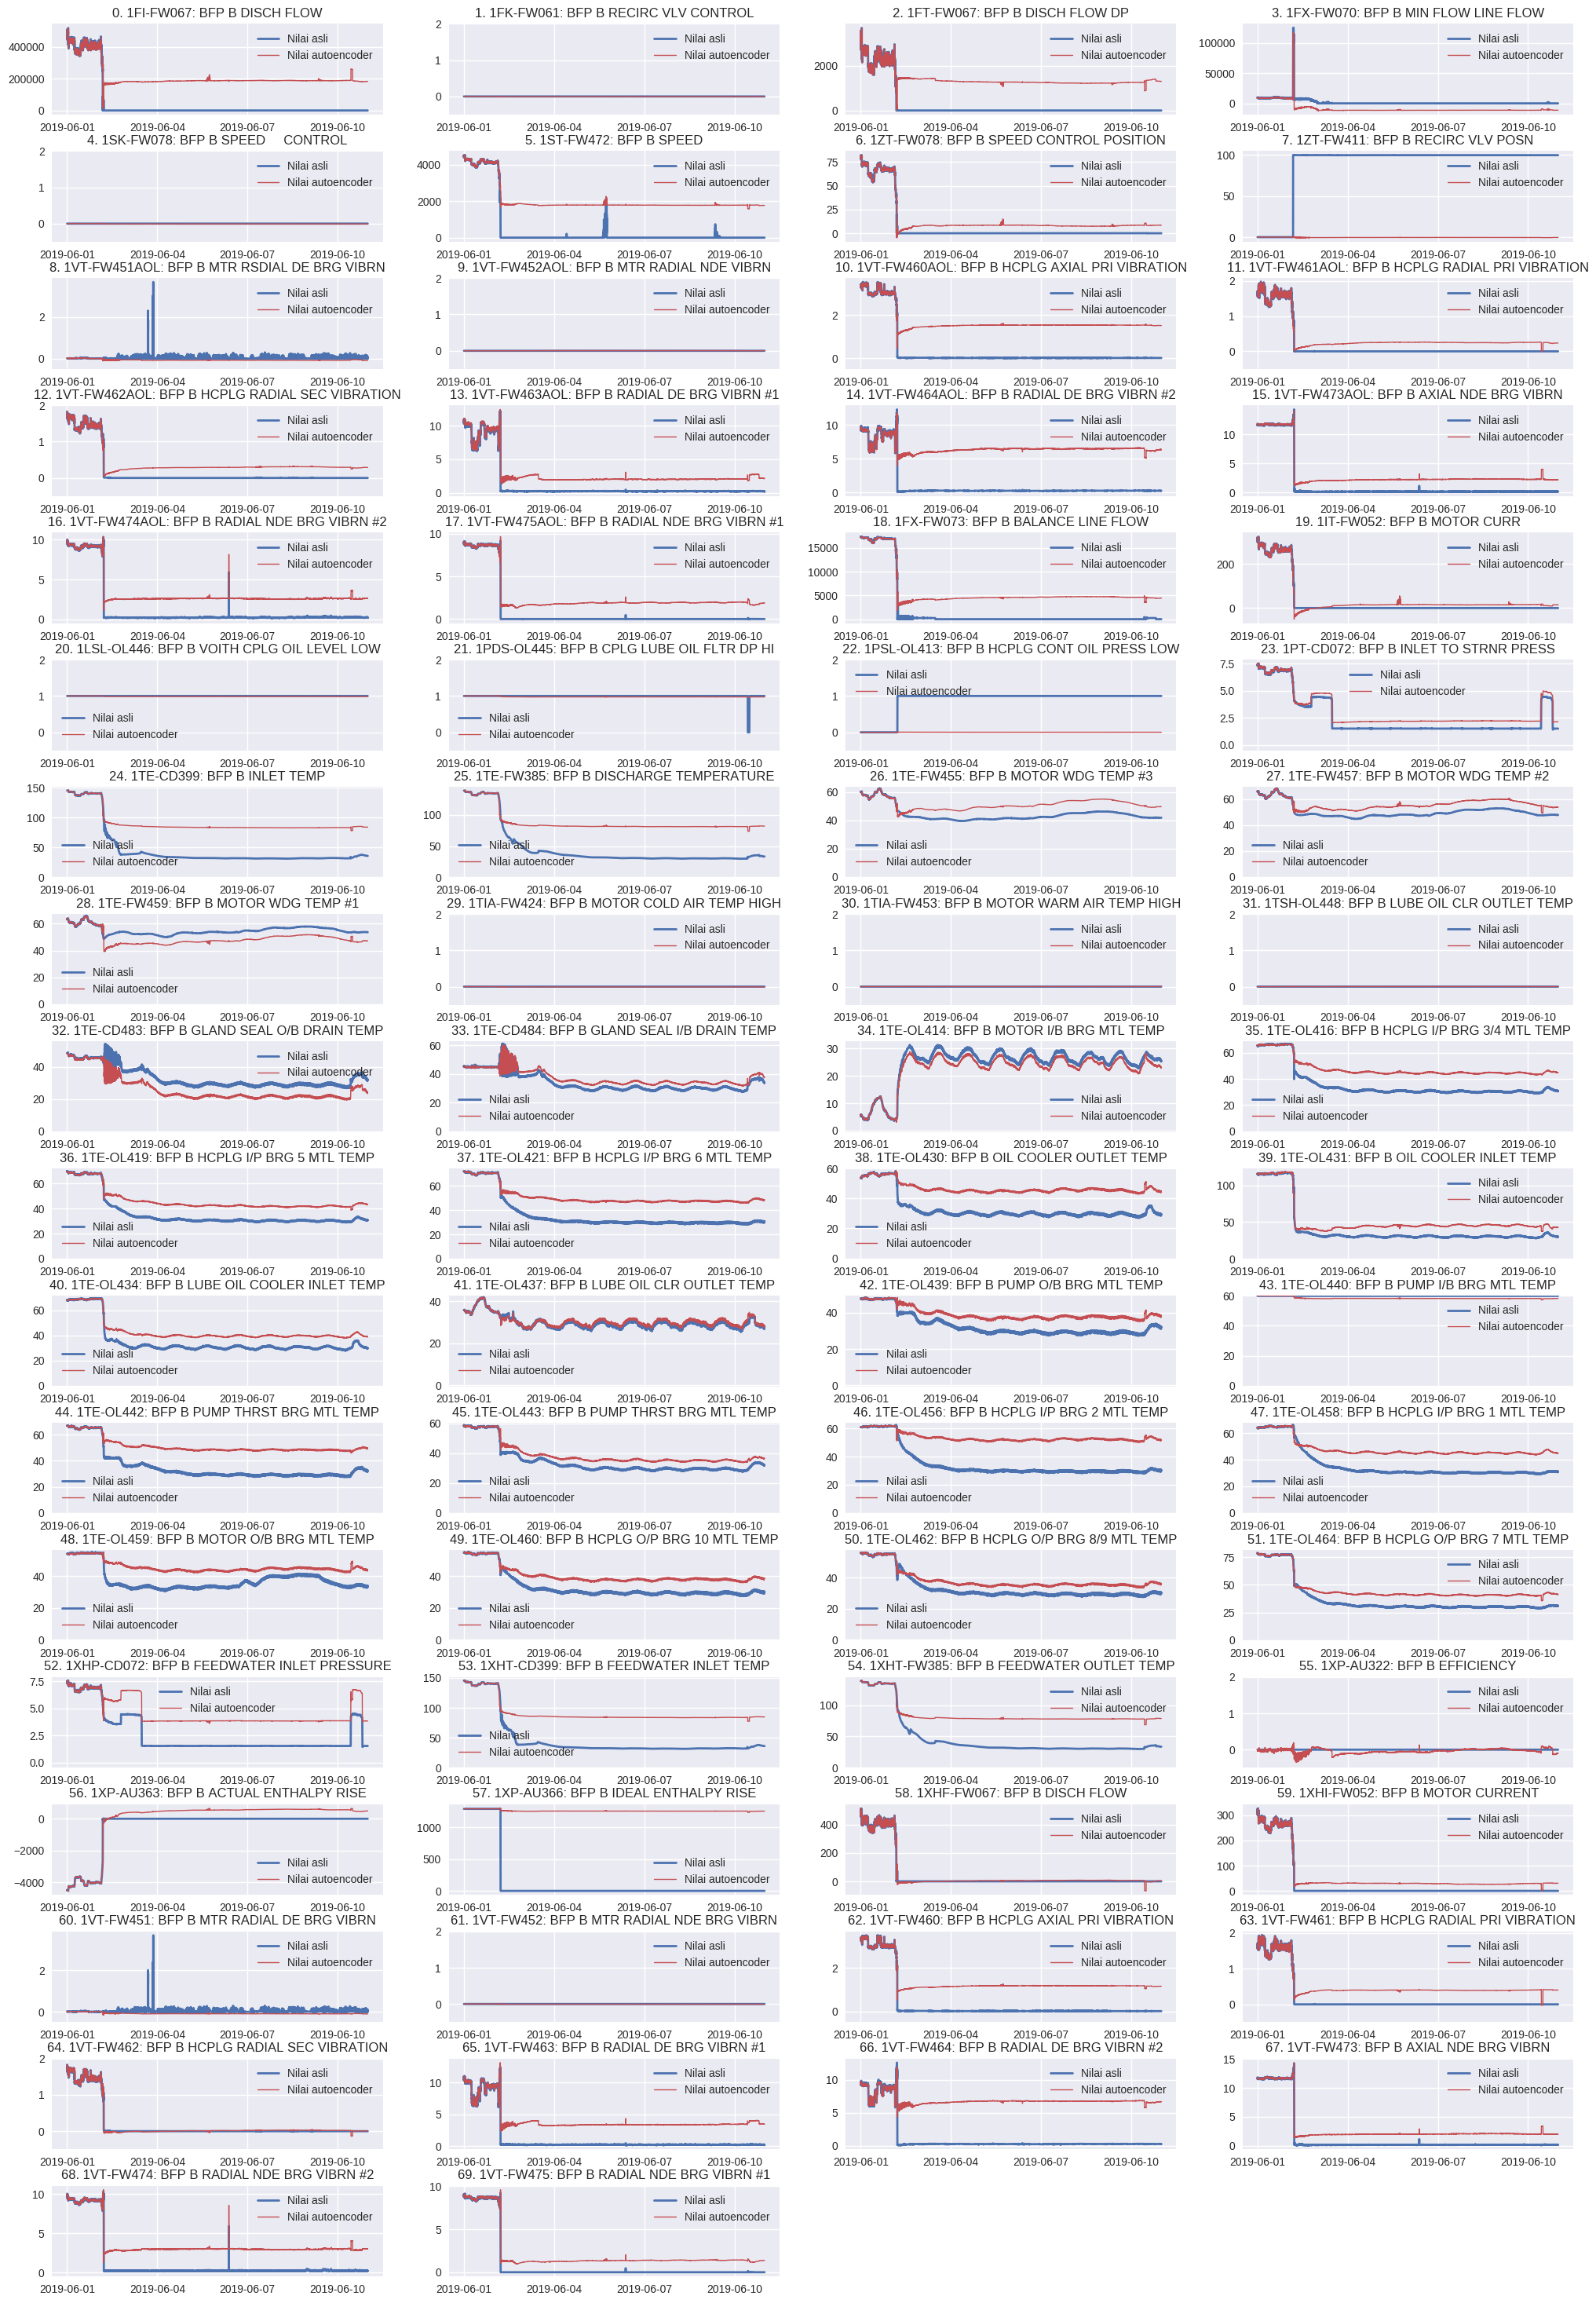

In [7]:
xlim = [np.datetime64('2019-06-01'), np.datetime64('2019-06-11')]
lim = [int(np.argwhere(timestamp == xlim[0])), int(np.argwhere(timestamp == xlim[1]))]
xticks = np.arange(xlim[0], xlim[1], np.timedelta64(3,'D'))
print(xticks)

plt.figure(figsize=(25,38))
n = 1
for i in range(len(bfpb.columns)):
    # plt.figure(figsize=(16,3))
    plt.subplot(18,4,n)
    plt.plot(timestamp[lim[0]:lim[1]], bfpb_arr[lim[0]:lim[1], i], c="C0", linewidth=2)
    plt.plot(timestamp[lim[0]:lim[1]], nilai_pred[lim[0]:lim[1], i], c="C2", linewidth=1)
    title = str(i) + '. ' + bfpb.columns[i] + ": " + sensorgroup['DESC'].loc[bfpb.columns[i]]
    plt.title(title)
    ylim = plt.ylim()
    plt.ylim([min(-.5, ylim[0]), max(2, ylim[1])])
    plt.xticks(xticks)
    plt.legend(['Nilai asli','Nilai autoencoder'])
    n += 1
plt.subplots_adjust(hspace=.4)
plt.show()

# Control chart
*Control chart* diperlukan untuk menentukan batas atas dan batas bawah yang didapatkan dari autoencoder untuk kita sebut sebagai anomali. Batas atas dan batas bawah ini ditentukan dengan berdasarkan output dari sinyal autoencoder, kemudian dihitung nilai rata-rata dan standar deviasinya sehingga mendapatkan angka batas atas (UL) dan batas bawah (LL). Rumus matematikanya sebagai berikut:

>$\displaystyle \bar{x} = \sum_{i=0}^w (\frac{1}{w} \times x_i) $

>$\displaystyle std = \sqrt{\frac{\sum_{i=1}^{n}(x_i - \bar{x})^2}{n-1}} $

>$\displaystyle SE = \frac{std}{\sqrt{w}}$

>$\displaystyle UL =\bar{x} + (3.0 \times SE) $

>$\displaystyle LL =\bar{x} - (3.0 \times SE) $

.

dimana :
>$w = $ time window yang ditentukan (18 time window)                            
>$\bar x =$ rata-rata dari $(w)$ nilai terakhir                                 
>$std=$ standar deviasi dengan $n$=jumlah data                                  
>$UL=$ Upper limit / batas atas                                               
>$LL=$ Lower limit / batas bawah                                                



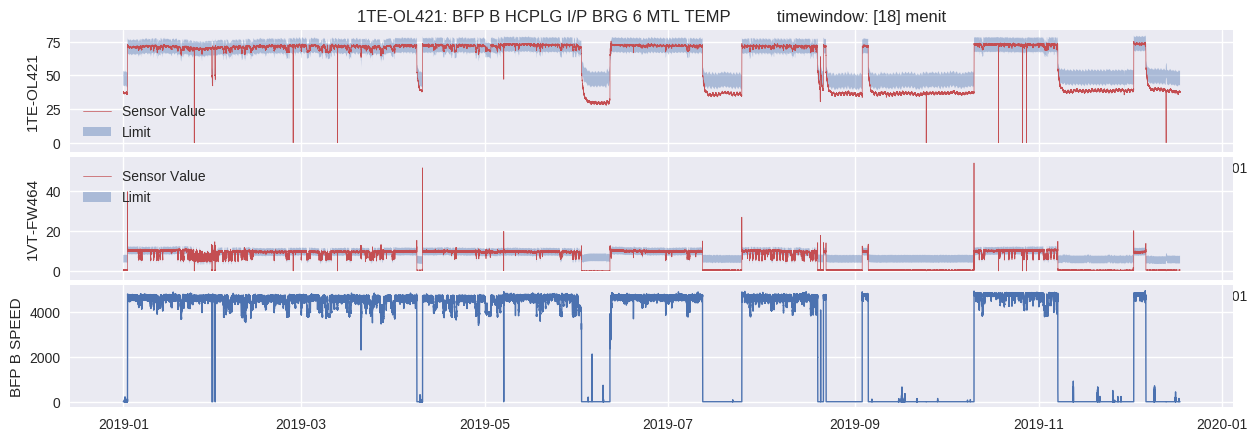

In [8]:
timewindow = 6*3
tag = 37
 
b = np.full(timewindow, 1/timewindow)
xbar = lfilter(b, [1], nilai_pred, axis=0)
# _ = pd.DataFrame(nilai_pred, columns=bfpb.columns, index=pdts)
# std = np.array(_.rolling(window=timewindow).var())
std = np.std(bfpb_arr[0:43839], axis=0)
# xbar = np.mean(bfpb_arr[0:43839], axis=0)

SE = std / np.sqrt(timewindow)
UL = xbar + 3.0 * SE
LL = xbar - 3.0 * SE

plt.figure(figsize=(15,5))
plt.subplot(311)
plt.fill_between(timestamp, UL[:,tag], LL[:,tag], alpha=0.4, label='Limit')
plt.plot(timestamp, bfpb_arr[:, tag], label="Sensor Value", c="C2", linewidth=0.5)
plt.legend(loc="lower left")
xlim = plt.xlim()
# xlim = plt.xlim(np.datetime64('2019-07-25 13:00'),np.datetime64('2019-08-26 13:00'))
plt.xlabel("Timestamp")
plt.ylabel(bfpb.columns[tag])
tw = (np.timedelta64(timestamp[timewindow]-timestamp[0], 'm')).flatten()
plt.title(f"{bfpb.columns[tag]}: {sensorgroup['DESC'].loc[bfpb.columns[tag]]}          timewindow: {tw} menit")

tag2 = 66
plt.subplot(312)
plt.fill_between(timestamp, UL[:,tag2], LL[:,tag2], alpha=0.4, label='Limit')
plt.plot(timestamp, bfpb_arr[:, tag2], label="Sensor Value", c="C2", linewidth=0.5)
plt.legend(loc="upper left")
# plt.ylim(6.5, 8.5)
xlim = plt.xlim(xlim)
plt.xlabel("Timestamp")
plt.ylabel(bfpb.columns[tag2])

plt.subplot(313)
plt.plot(timestamp, bfpb["1ST-FW472"].to_numpy(), linewidth=1)
# plt.xlim(timestamp[43300], timestamp[43900])
plt.ylabel(sensorgroup["DESC"].loc['1ST-FW472'])
plt.xlim(xlim)
plt.subplots_adjust(hspace=.045)
plt.show()

In [9]:
colr = bfpb_arr[:,tag] < UL[:,tag]
colr = colr.astype('int')
data = np.array([timestamp, bfpb_arr[:, tag], colr]).T
dtplot = pd.DataFrame(data = data, columns = ['timestamp', bfpb.columns[tag], 'HALARM'])
dtplot['timestamp'] = pd.to_datetime(dtplot['timestamp'])
dtplot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505440 entries, 0 to 505439
Data columns (total 3 columns):
timestamp    505440 non-null datetime64[ns]
1TE-OL421    505440 non-null object
HALARM       505440 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 11.6+ MB


In [17]:
le = 350000
li = 400000
step = 30

fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(timestamp[le:li:step]), y=UL[le:li:step,tag],
    fill=None,
    mode='lines',
    line_color='skyblue',
    name='Upper limit'
    ))
fig.add_trace(go.Scatter(
    x=pd.to_datetime(timestamp[le:li:step]),
    y=LL[le:li:step,tag],
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='skyblue',
    name='Lower limit'))

fig.add_trace(go.Scatter(
    x=dtplot['timestamp'].iloc[le:li:step], y=dtplot[bfpb.columns[tag]].iloc[le:li:step],
    mode='markers', name='Sensor value',
    hovertemplate = 'Time: $%{x:.2f}'+ '<br>val: %{y}<br>'+ 'Alarm: %{text}',
    text = dtplot['HALARM'].iloc[le:li:step].values,
))

title = bfpb.columns[tag] + ' -> ' + sensorgroup['DESC'].loc[bfpb.columns[tag]]
fig.update_layout(title=title)
fig.show()

# Posisi alarm
Deskripsi alarm dari kami adalah ketika ada lebih dari **10** tag yang nilainya di atas Upper Limit, kemudian kejadian tersebut berlangsung selama lebih dari **3** jam, maka kami anggap anomali. Dari kategori tersebut, maka dapat ditentukan beberapa timestamp yang kami anggap anomali. Berikut ini adalah letak timestamp yang anomali.

In [0]:
alarm = bfpb_arr > UL
halarm = []
jmltagalarm = 10
jamalarm = 3

tserror = []
deltatimes = []

jml = 0
for i in range(len(alarm)):
    if np.sum(alarm[i]) > jmltagalarm:
        jml += 1
    else:
        if halarm[-1] < jamalarm * 60 and halarm[-1] > 5:
            t1 = pd.to_datetime(timestamp[i-halarm[-1]])
            t2 = pd.to_datetime(timestamp[i])
            dt = t2-t1
            deltatimes.append([np.datetime64(t1, 'm'), np.datetime64(t2, 'm')])
            # print(t1, 'sampai', t2, "=>", dt)
        jml = 0
    halarm.append(jml)
halarm = np.array(halarm)
deltatimes = np.array(deltatimes)

2019-01-10 04:17:00  sampai  2019-01-10 04:23:00.   Selama 0 days 00:06:00
2019-01-12 04:48:00  sampai  2019-01-12 04:57:00.   Selama 0 days 00:09:00
2019-01-12 08:41:00  sampai  2019-01-12 08:49:00.   Selama 0 days 00:08:00
2019-01-23 04:52:00  sampai  2019-01-23 05:03:00.   Selama 0 days 00:11:00
2019-01-24 14:07:00  sampai  2019-01-24 14:24:00.   Selama 0 days 00:17:00
2019-02-07 05:13:00  sampai  2019-02-07 05:19:00.   Selama 0 days 00:06:00
2019-02-10 15:57:00  sampai  2019-02-10 16:13:00.   Selama 0 days 00:16:00
2019-02-26 10:23:00  sampai  2019-02-26 10:40:00.   Selama 0 days 00:17:00
2019-03-09 18:07:00  sampai  2019-03-09 18:19:00.   Selama 0 days 00:12:00
2019-03-09 18:20:00  sampai  2019-03-09 18:29:00.   Selama 0 days 00:09:00
2019-03-13 04:49:00  sampai  2019-03-13 05:06:00.   Selama 0 days 00:17:00
2019-03-20 23:32:00  sampai  2019-03-20 23:58:00.   Selama 0 days 00:26:00
2019-03-21 00:30:00  sampai  2019-03-21 01:43:00.   Selama 0 days 01:13:00
2019-03-21 01:48:00  samp

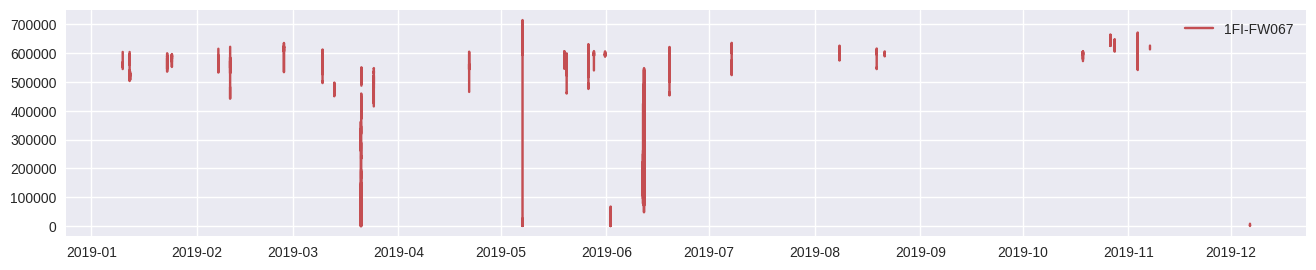

In [12]:
plt.figure(figsize=(16,3))
for dt in deltatimes:
    arg = [int(np.argwhere(timestamp == dt[0])), int(np.argwhere(timestamp == dt[1]))]
    plt.plot(timestamp[arg[0]:arg[1]], bfpb['1FI-FW067'].iloc[arg[0]:arg[1]], c='C2')
    t1 = pd.to_datetime(timestamp[arg[0]])
    t2 = pd.to_datetime(timestamp[arg[1]])
    print(f"{t1}  sampai  {t2}.   Selama {t2-t1}")

n = 0
plt.legend(["1FI-FW067"])
plt.show()

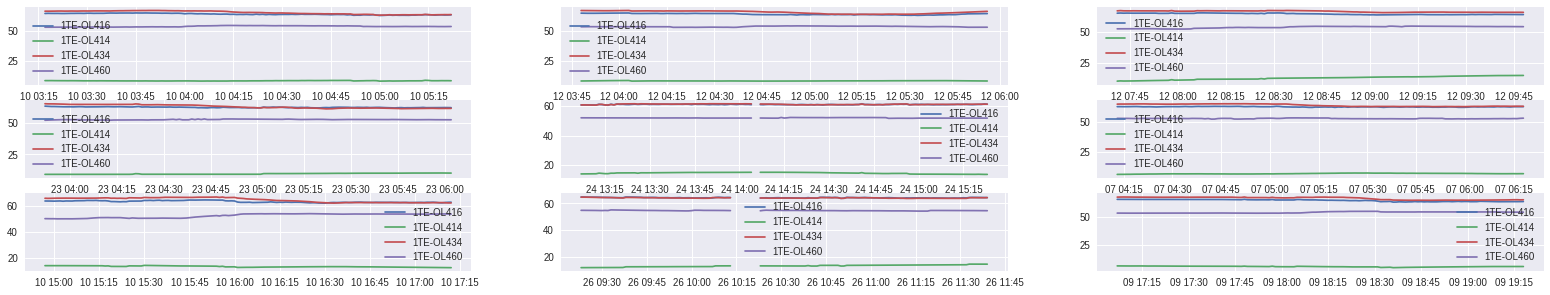

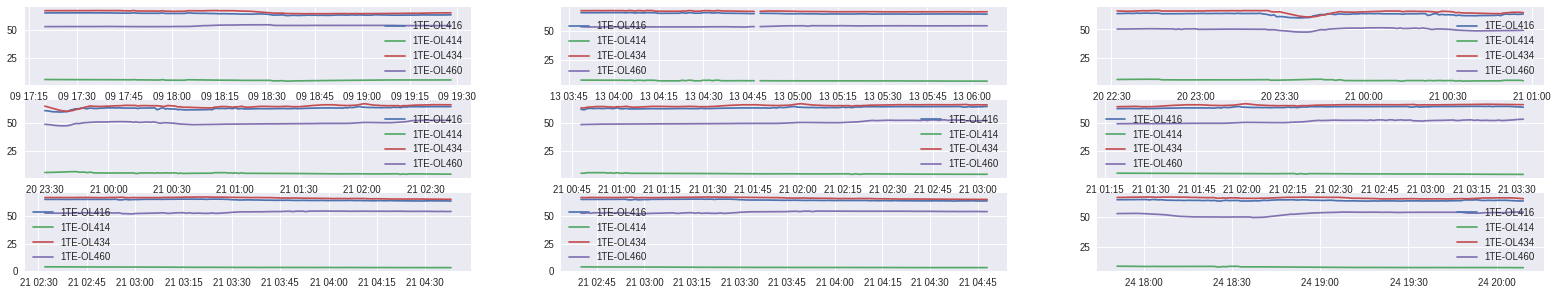

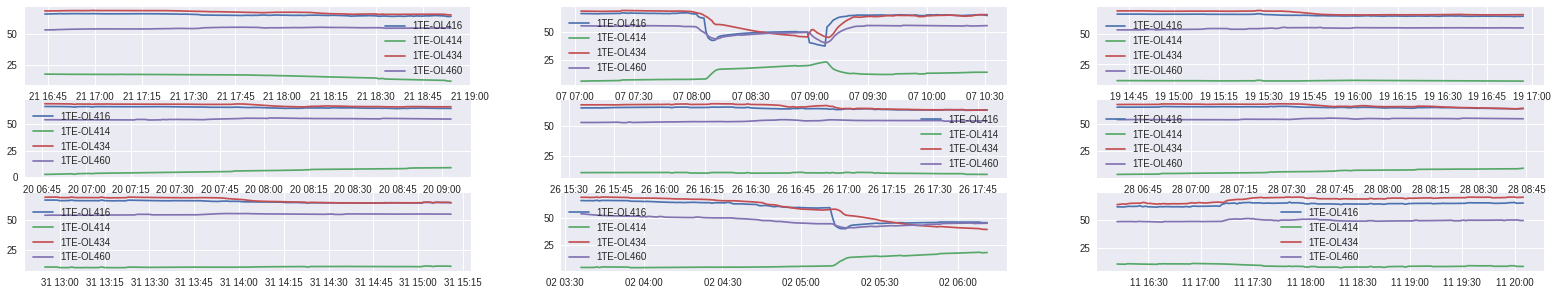

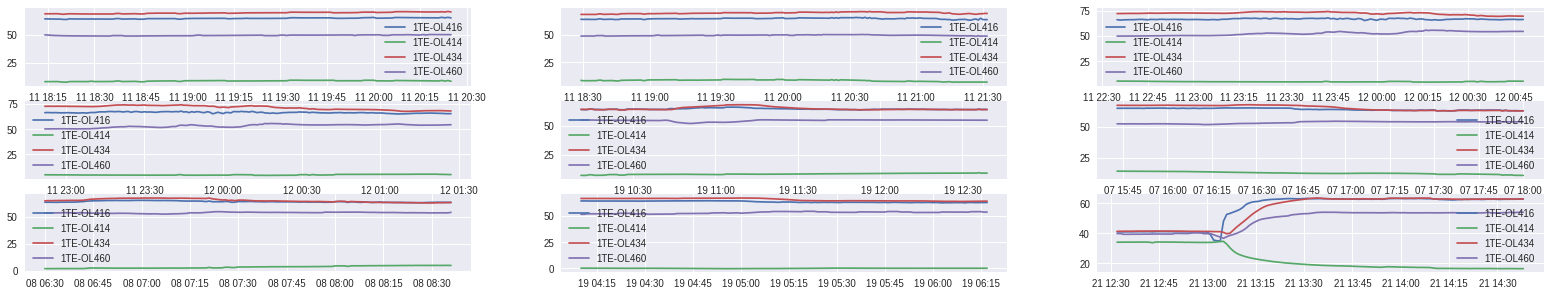

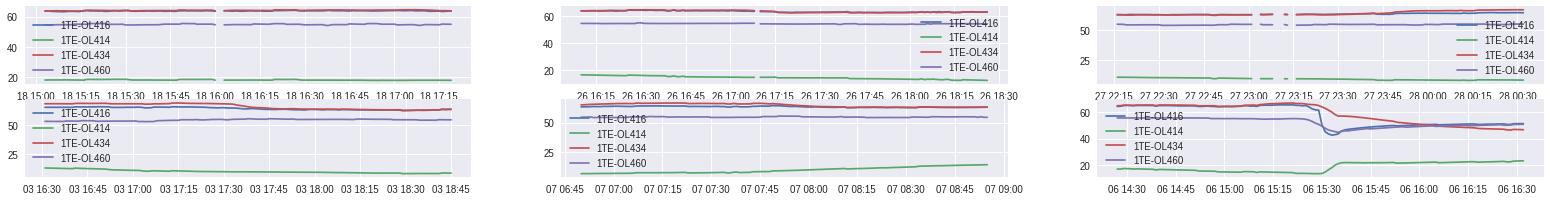

In [13]:
for dt in deltatimes:
    if n <= 0:
        plt.figure(figsize=(28,5), dpi=70)
        n = 9
    arg = [int(np.argwhere(timestamp == dt[0])), int(np.argwhere(timestamp == dt[1]))]
    plt.subplot(3,3,10-n)
    plt.plot(timestamp[arg[0]-60:arg[1]+60], bfpb['1TE-OL416'].iloc[arg[0]-60:arg[1]+60], label='1TE-OL416')
    plt.plot(timestamp[arg[0]-60:arg[1]+60], bfpb['1TE-OL414'].iloc[arg[0]-60:arg[1]+60], label='1TE-OL414')
    plt.plot(timestamp[arg[0]-60:arg[1]+60], bfpb['1TE-OL434'].iloc[arg[0]-60:arg[1]+60], label='1TE-OL434')
    plt.plot(timestamp[arg[0]-60:arg[1]+60], bfpb['1TE-OL460'].iloc[arg[0]-60:arg[1]+60], label='1TE-OL460')
    n -= 1
    plt.legend()